# 0.0 Imports

In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inflection
from pandas_profiling import ProfileReport
from boruta import BorutaPy

from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from IPython.display import Image
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper functions

In [2]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
    
#     sns.set()
# jupyter_settings()

In [3]:
def cross_validation(X_train, y_train, n_folds, model_name, model, verbose=True):
    # generate k-fold
    f1_scores = []
    n_folds = n_folds
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    i=1
    if verbose:
        for train_ix, val_ix in kfold.split(X_train, y_train):
            print('Fold Nº: {}/{}'.format(i, n_folds))
            # get fold
            X_train_fold = X_train.iloc[train_ix]
            y_train_fold = y_train.iloc[train_ix]

            X_val_fold = X_train.iloc[val_ix]
            y_val_fold = y_train.iloc[val_ix]


            # training model
            m = model.fit(X_train_fold, y_train_fold)

            # prediction
            pred_val = m.predict(X_val_fold)

            # metric
            # F1-Score
            f1_fold = f1_score(pred_val,y_val_fold)
            f1_scores.append(f1_fold)

            i +=1
    return pd.DataFrame({'Model Name': model_name,
                         'Avg F1-Score':np.round(np.mean(f1_scores),3).astype(str)+ '+/-' + np.round(np.std(f1_scores),3).astype(str)}, index=[0])

In [4]:
def f1_score_metric(model_name, y_test, pred):
    return pd.DataFrame({'Model Name': model_name,
                        'F1 Score': f1_score(pred,y_test).round(3)}, index=[0])

## 0.2 Load Data

In [5]:
df = pd.read_csv('..\churn.csv')
df.drop('RowNumber', axis=1, inplace=True)

# 1.0 Data Description

In [6]:
df1 = df.copy()

## 1.2 Rename Columns

In [9]:
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3 Data Types

In [10]:
# Data types seem correct by default
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Null  Values

In [11]:
# No NAs
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

# 2.0 Feature Engeenering

In [17]:
df2 = df1.copy()

## 2.1 Feature Creation

Annual Revenue (per customer)

In [19]:
## Try - List comprehension
# df2['anual_revenue'] = [ (salary *0.15) if (salary < df2['estimated_salary'].mean()) else (salary *0.20) if (salary > df2['estimated_salary'].mean()) for salary in df2['estimated_salary']]

anual_revenue = []
for salary in df2['estimated_salary']:
    if salary < df2['estimated_salary'].mean():
        anual_revenue.append(salary*0.15)
    elif salary > df2['estimated_salary'].mean():
        anual_revenue.append(salary*0.20)
df2['anual_revenue'] = pd.Series(anual_revenue)

# 3.0 Feature Filtering

In [20]:
df3 = df2.copy()

In [21]:
df3.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,anual_revenue
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,20269.7760
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,22508.5160
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,22786.3140
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,14073.9945
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,11862.6150


## 3.1 Column Filtering

In [21]:
# Drop customer_id and surname
df3.drop(['customer_id','surname'], axis=1, inplace=True)

In [22]:
df3[df3.estimated_salary<1000].is_active_member.value_counts()

1    36
0    23
Name: is_active_member, dtype: int64

# 5.0 Data Preparation

In [62]:
df5 = df3.copy()

## 5.1. Categorical Variables

In [63]:
# One-hot Encoding - Geography
df5 = pd.get_dummies( df5, prefix=['geography'], columns=['geography'] )

# Label encoding - Gender
df5['gender'] = [1 if gender == 'Male' else 2 for gender in df5['gender']]

## 5.2 Numerical Variables

In [64]:
# Normalization - Almost normal distribution features
ss = StandardScaler()

df5['age'] = ss.fit_transform(df5[['age']].values)
df5['credit_score'] = ss.fit_transform(df5[['credit_score']].values)

pickle.dump(ss, open('src/standard_scaler.pkl', 'wb') )

# Rescaling - Non-Normal distribuited features
mms = MinMaxScaler(feature_range=(0, 1))

df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)
df5['anual_revenue'] = mms.fit_transform(df5[['anual_revenue']].values)

pickle.dump(mms, open('src/minmax_scaler.pkl', 'wb') )

# Robust Scaler
rs = RobustScaler()

df5['balance'] = rs.fit_transform(df5[['balance']].values)

pickle.dump(rs, open('src/robust_scaler.pkl', 'wb') )

In [65]:
# Check data preparation
df5.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,anual_revenue,geography_France,geography_Germany,geography_Spain
0,-0.326221,2,0.293517,0.2,-0.761480,1,1,1,0.506735,1,0.506742,1,0,0
1,-0.440036,2,0.198164,0.1,-0.104906,1,0,1,0.562709,0,0.562715,0,0,1
2,-1.536794,2,0.293517,0.8,0.489346,3,1,0,0.569654,1,0.569661,1,0,0
3,0.501521,2,0.007457,0.1,-0.761480,2,0,0,0.469120,0,0.351835,1,0,0
4,2.063884,2,0.388871,0.2,0.221806,1,1,1,0.395400,0,0.296546,0,0,1


## 5.3 Balancing Data - Oversampling with SMOTE

In [66]:
# Using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df5.loc[:,df5.columns != 'exited'], df5.exited)

In [67]:
print("The dataset's shape after the balancing has {} data points.".format(X_smote.shape[0]))

The dataset's shape after the balancing has 15926 data points.


# 6.0 Feature Selection

In [68]:
df6 = df5.copy()

## 6.1 Train and Test Datasets

In [69]:
# Already balanced X and Y
X=X_smote
y=y_smote

# Train and test spliT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# 7.0 Machine Learning Modelling

In [72]:
df7 = df6.copy()

### 7.3.1 XGBoost - Cross Validation

In [82]:
# Model definition

xgb = XGBClassifier(random_state=42)#,eval_metric='mlogloss', use_label_encoder=False) #set eval_metric as mlogloss to avoid disfunction in the deploy

# Cross Validation

cross_validation(X_train, y_train, 10, 'XGBoost', xgb, verbose=True)

Fold Nº: 1/10
[18:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 2/10
[18:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 3/10
[18:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Nº: 4/10
[18:41:13] WAR

,Model Name,Avg F1-Score
0,XGBoost,0.901+/-0.008


### 7.3.2 XGBoost - Prediction

In [83]:
# Model Training
xgb.fit(X_train, y_train)

# Prediction 
pred_xgb = xgb.predict(X_test)

# Performance
f1_xgb = f1_score_metric('XGBoost',y_test,pred_xgb)
f1_xgb

# Save model to pickle
# pickle.dump(xgb, open('src/model_xgb.pkl', 'wb'))

[18:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 7.3.3 XGBoost - Calibration Curve

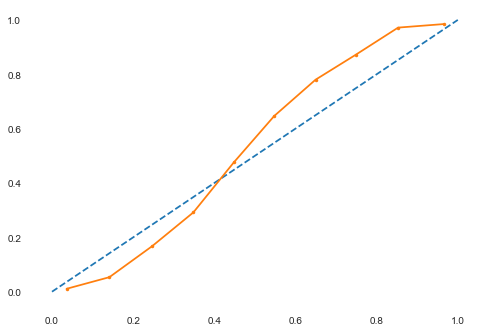

In [84]:
## WITHOUT CALIBRATION
# Predict probabilities for THE WHOLE DATASET
prob_xgb_full = xgb.predict_proba(df7[X_test.columns])[:,1]

fop_xgb, mpv_xgb = calibration_curve(df7.exited, prob_xgb_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv_xgb,fop_xgb, marker='.')
plt.show()

[18:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

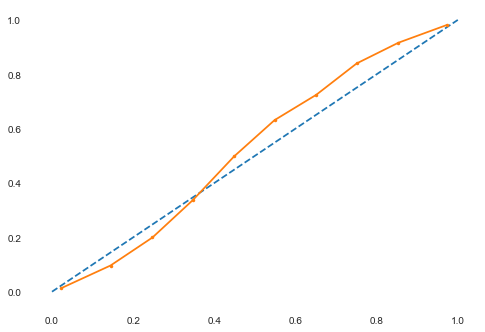

In [85]:
## CALIBRATION WITH CalibratedClassifierCV
calibration = CalibratedClassifierCV(xgb, method='sigmoid',cv=5)
calibration.fit(X_train,y_train)

# Predict probabilities for THE WHOLE DATASET
prob_xgb_full = calibration.predict_proba(df7[X_test.columns])[:,1]

fop_xgb, mpv_xgb = calibration_curve(df7.exited, prob_xgb_full, n_bins=10, normalize=True)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(mpv_xgb,fop_xgb, marker='.')
plt.show()

In [86]:
xgb.save_model('model_xgb.model')

# 8.0 Hyperparameter Fine-Tunning

In [92]:
df8 = df7.copy()

# 9.0 Churn Analysis

In [93]:
df9 = df8.copy()

In [94]:
df_prob = df2.copy()

# Model elected: XGBoost

df_prob['prob'] = prob_xgb_full

In [95]:
# Mean churn rate
print('The mean churn rate is {:.0%}'.format(np.round(df_prob.prob.mean(),3)))
print('The mean churn rate is close to the actual percentage of clients in churn in the dataset, which is 20.4%')

The mean churn rate is 23%
The mean churn rate is close to the actual percentage of clients in churn in the dataset, which is 20.4%


Mean churn rate without the actual churned clients is 11%


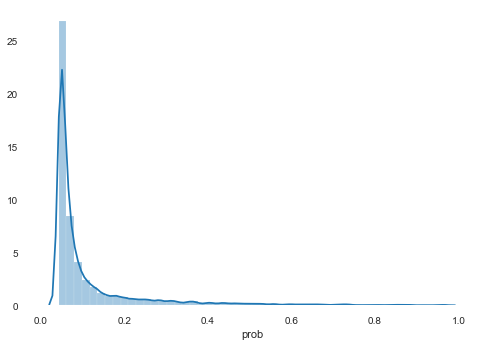

In [96]:
print('Mean churn rate without the actual churned clients is {:.0%}'.format(df_prob.loc[df_prob.exited==0, 'prob'].mean()));
# Distribution of churn probabilities to non-churned clients
sns.distplot(df_prob.loc[df_prob.exited==0, 'prob']);

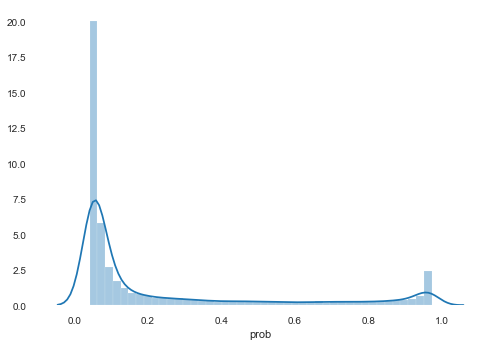

In [97]:
# Churn probability distribution to all clients
sns.distplot(df_prob.prob);

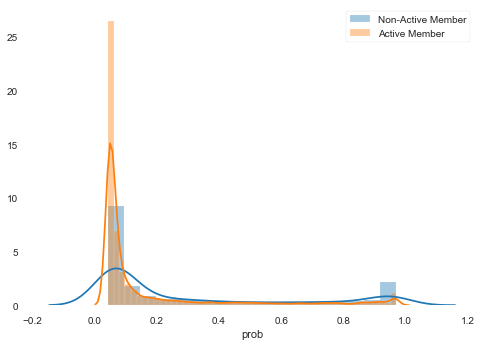

In [98]:
sns.distplot(df_prob[df_prob.is_active_member ==0]['prob'], label='Non-Active Member');

sns.distplot(df_prob[df_prob.is_active_member ==1]['prob'], label='Active Member');
plt.legend()
plt.show()

As it would normally be figured, active members have more lower probabilities to churn in comparasion to non-active members. Moreover, non-active members have slighty more higher probabilities to churn in relation to active members.

# 10.0 Bussiness Report and Financial Impact

* Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?

In [99]:
print('A taxa atual média de churn da TopBank é {:.0%}. Para uma análise de sua variação mensal é requerido uma maior coleta de dados e a alteração de sua granualiridade.'.format(np.round(df_prob.prob.mean(),3)))

A taxa atual média de churn da TopBank é 23%. Para uma análise de sua variação mensal é requerido uma maior coleta de dados e a alteração de sua granualiridade.


* Qual a Performance do modelo em classificar os clientes como churns?

In [100]:
print('A partir da métrica F1 score, pode-se afirmar que o modelo possui uma excelente performance em classificar os clientes como churns, com um valor de 0.905')
f1_xgb

A partir da métrica F1 score, pode-se afirmar que o modelo possui uma excelente performance em classificar os clientes como churns, com um valor de 0.905


,Model Name,F1 Score
0,XGBoost,0.905


## 10.1 Bussiness Analysis

* Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento), tendo em vista que a soma dos incentivos não pode ultrapassar os 10.000,00?
Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

A designação dos cupons de desconto envolve assumir diferentes cenários:

1) **Idealista**: dar os incentivos (por exemplo, no valor de $100) fará com que todos os beneficiários permaneçam na empresa.

2) **Realista**: os incentivos variam de acordo com a probabilidade do cliente entrar em churn.

* Clientes que entrarão em churn independemente de incentivo: p(churn) > 0.90

* Clientes que talvez permanecerão, mas somente com um incentivo de $200:
0.80 < p(churn) < 0.89

* Clientes que permenecerão com incentivo de $100: 0.75 < p(churn) < 0.79

* Clientes que permencerão com incenttivo de $50: p(churn) < 0.75

In [101]:
# Creating a Dataframe with only the churned clients
df_prob_churn = df_prob[df_prob.exited==1]

# Creating a DataFrame with the probabilities to churn, the LTV, the gift cost and the ROI
df_result = pd.DataFrame()
df_result['customer_id'] = df_prob_churn.customer_id
df_result['prob'] = df_prob_churn.prob
df_result['LTV'] = df_prob_churn.anual_revenue

conditions = [
    (df_result['prob'] >= 0.9),
    (df_result['prob'] >= 0.8) & (df_result['prob'] < 0.9),
    (df_result['prob'] >= 0.75) & (df_result['prob'] < 0.8),
    (df_result['prob'] < 0.75)
    ]
cost = [np.nan, 200, 100,50]

# Designate gift cost according to churn probabilities
df_result['gift_cost'] = np.select(conditions, cost)

# Calculate the ROI (LTV - gift cost)
df_result['ROI'] = df_result.LTV - df_result.gift_cost

df_result.head()

,customer_id,prob,LTV,gift_cost,ROI
0,15634602,0.325068,20269.7760,50.0,20219.776
2,15619304,0.970246,22786.3140,NaN,NaN
5,15574012,0.413826,29951.3420,50.0,29901.342
7,15656148,0.971168,23869.3760,NaN,NaN
16,15737452,0.969591,764.6505,NaN,NaN


In [102]:
# Select only the clients that may not churn and sort by the ROI
selected_gifts = df_result.loc[(df_result.prob > 0.7) & (df_result.prob < 0.9)].sort_values(['ROI'], ascending=False)

print('At this point, we went from the {0} total clients in churn to only {1} selected clients by ROI and their according viable probabilities.'.format(df_prob_churn.shape[0],selected_gifts.shape[0]))

At this point, we went from the 2037 total clients in churn to only 494 selected clients by ROI and their according viable probabilities.


In [103]:
# Selecting the customers to receive the gift card according to the limited budget
total_sum = 0
customers = []

for customer, gift in zip(selected_gifts.customer_id,selected_gifts.gift_cost):
    total_sum = total_sum + gift
    # Selection goes up to the amount of gift card we can spend, which is $10.000
    if total_sum > 10000:
        break
    # Add client to list
    customers.append(customer)
    
# Create final Dataframe
selected_customers = selected_gifts[selected_gifts.customer_id.isin(customers)]
selected_customers.head(10)

,customer_id,prob,LTV,gift_cost,ROI
8088,15815656,0.886659,39961.620,200.0,39761.620
118,15661670,0.875108,39945.078,200.0,39745.078
5087,15624641,0.824601,39858.136,200.0,39658.136
458,15707362,0.888151,39854.796,200.0,39654.796
2786,15585100,0.820317,39762.848,200.0,39562.848
8212,15621004,0.716373,39611.188,50.0,39561.188
3490,15809137,0.810676,39675.204,200.0,39475.204
4295,15616454,0.753235,39444.362,100.0,39344.362
7876,15757607,0.768849,39306.744,100.0,39206.744
7397,15744044,0.872594,39309.970,200.0,39109.970


* Note: the solution was not totally optimal once we did not automatized the gift card distribution. In other words, we spent only 9850 from the total budget, which means that we could still, for example, include a 100 and a 50 gift card clients.

Respondendo à pergunta:

In [104]:
print('The financial incentive (gift card) included {} customers from the total {} customers in churn.'.format(selected_customers.customer_id.nunique(), df_prob_churn.shape[0]))
print('It could be expected to return a ROI of ${}.'.format(selected_customers.ROI.sum().round(2)))
print('The total lost revenue if we expect all customers to churn is ${}. This means that we could save {:.0%} of revenue from using this model to prevent customers to churn.'.format(df_prob_churn.anual_revenue.sum().round(2),selected_customers.ROI.sum().round(2)/df_prob_churn.anual_revenue.sum().round(2)))

The financial incentive (gift card) included 70 customers from the total 2037 customers in churn.
It could be expected to return a ROI of $2596506.6.
The total lost revenue if we expect all customers to churn is $38846324.63. This means that we could save 7% of revenue from using this model to prevent customers to churn.


# 10.0 Deploy

## 10.1 Churn Probability Class

In [107]:
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

class ChurnProbability():
    
    def __init__(self):
        self.home_path = 'C:\\Users\\Dell\\Desktop\\ciencia_de_dados\\0.Comunidade DS\\PA_03'
        self.standard_scaler = pickle.load(open(self.home_path + 'src/standard_scaler.pkl', 'rb'))
        self.minmax_scaler = pickle.load(open(self.home_path + 'src/minmax_scaler.pkl', 'rb'))
        self.robust_scaler = pickle.load(open(self.home_path + 'src/robust_scaler.pkl', 'rb'))
        self.model = pickle.load(open(self.home_path + 'src/model_xgb.pkl', 'rb'))
    
    def get_customer_id(self,data)
        customers_id = data.customer_id
        df_raw = data
        return customers_id, df_raw
    
    def feature_engeneering(self,data):
        
        # Rename colunms
        cols_old = data.columns.to_list()
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        data.columns = cols_new

        # Feature Engeneering - Annual Revenue
        anual_revenue = []
        for salary in data['estimated_salary']:
            if salary < data['estimated_salary'].mean():
                anual_revenue.append(salary*0.15)
            elif salary > data['estimated_salary'].mean():
                anual_revenue.append(salary*0.20)
        data['anual_revenue'] = pd.Series(anual_revenue)

        # Feature Filtering
        # Drop customer_id and surname
        data.drop(['customer_id','surname'], axis=1, inplace=True)
        
        return data

    def data_preparation(self, data): 

        ## Categorical Variables

        # One-hot Encoding - Geography
        data = pd.get_dummies( data, prefix=['geography'], columns=['geography'] )

        # Label encoding - Gender
        data['gender'] = [1 if gender == 'Male' else 2 for gender in data['gender']]

        ## Numerical Variables

        # Normalization - Almost normal distribution features
        data['age'] = self.standard_scaler.fit_transform(data[['age']].values)
        data['credit_score'] = self.standard_scaler.fit_transform(data[['credit_score']].values)

        # Rescaling - Non-Normal distribuited features
        data['tenure'] = self.minmax_scaler.fit_transform(data[['tenure']].values)
        data['estimated_salary'] = self.minmax_scaler.fit_transform(data[['estimated_salary']].values)
        data['anual_revenue'] = self.minmax_scaler.fit_transform(data[['anual_revenue']].values)

        # Robust Scaler
        data['balance'] = self.robust_scaler.fit_transform(data[['balance']].values)

        return data
    
    def data_balacing(self, data):
        # Data Balacing using SMOTE
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(data.loc[:,data.columns != 'exited'], data.exited)

        # Already balanced X and Y
        X=X_smote
        y=y_smote

        return X,y
    
    def get_proba(self,data,X,y):
        ## CALIBRATION WITH CalibratedClassifierCV
        calibration = CalibratedClassifierCV(self.model, method='sigmoid',cv=5)
        calibration.fit(X,y)

        # Predict probabilities for THE WHOLE DATASET
        prob_xgb_full = calibration.predict_proba(data[X.columns])[:,1]
        
        return prob_xgb_full
    
    def get_df_prob(self, df_raw, prob):
        df_raw['prob'] = prob
        
        return df_raw
    
    def get_gifted_customers(self, df_prob, limited_budget):
        # Creating a Dataframe with only the churned clients
        df_prob_churn = df_prob[df_prob.exited==1]

        # Creating a DataFrame with the probabilities to churn, the LTV, the gift cost and the ROI
        df_result = pd.DataFrame()
        df_result['customer_id'] = df_prob_churn.customer_id
        df_result['prob'] = df_prob_churn.prob
        df_result['LTV'] = df_prob_churn.anual_revenue

        conditions = [
            (df_result['prob'] >= 0.9),
            (df_result['prob'] >= 0.8) & (df_result['prob'] < 0.9),
            (df_result['prob'] >= 0.75) & (df_result['prob'] < 0.8),
            (df_result['prob'] < 0.75)
            ]
        cost = [np.nan, 200, 100,50]

        # Designate gift cost according to churn probabilities
        df_result['gift_cost'] = np.select(conditions, cost)

        # Calculate the ROI (LTV - gift cost)
        df_result['ROI'] = df_result.LTV - df_result.gift_cost
        
        # Select only the clients that may not churn and sort by the ROI
        selected_gifts = df_result.loc[(df_result.prob > 0.7) & (df_result.prob < 0.9)].sort_values(['ROI'], ascending=False)

        # Selecting the customers to receive the gift card according to the limited budget
        total_sum = 0
        customers = []

        for customer, gift in zip(selected_gifts.customer_id,selected_gifts.gift_cost):
            total_sum = total_sum + gift
            # Selection goes up to the amount of gift card we can spend, which is $10.000
            if total_sum > limited_budget:
                break
            # Add client to list
            customers.append(customer)

        # Create final Dataframe
        gifted_customers = selected_gifts[selected_gifts.customer_id.isin(customers)]
        
        return gifted_customers

In [112]:
df_prob.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,anual_revenue,prob
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,20269.7760,0.325068
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,22508.5160,0.098526
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,22786.3140,0.970246
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,14073.9945,0.065143
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,11862.6150,0.047572
